In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import bemcs

# Two-element model geometry
- Three points, $\mathrm{a}$, $\mathrm{b}$, and $\mathrm{c}$
- Two elements $\mathrm{ab}$ and $\mathrm{bc}$

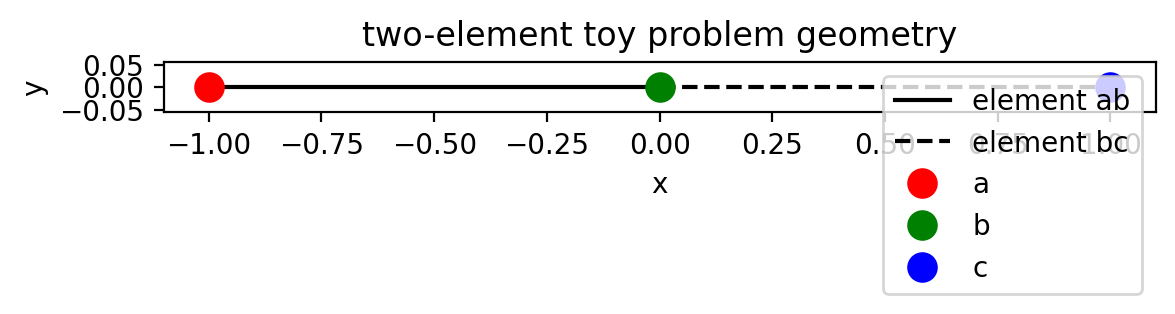

In [17]:
markersize = 20
plt.figure()
plt.plot([-1, 0], [0, 0], "-k", label="element ab")
plt.plot([0, 1], [0, 0], "--k", label="element bc")
plt.plot(-1, 0, "r.", label="a", markersize=markersize)
plt.plot(0, 0, "g.", label="b", markersize=markersize)
plt.plot(1, 0, "b.", label="c", markersize=markersize)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.gca().set_aspect("equal")
plt.title("two-element toy problem geometry")
plt.show()


# Constructing continous quadratic slip across two elements
The goal is for both slip, and it's derivative, to be continuous everhwere including, critcally, at points $\mathrm{b}$ the junction between elements $\mathrm{ab}$ and $\mathrm{bc}$ 

## Basic slip functions over each element
For the element $\mathrm{ab}$ the element slip is defined by,

$ y_\mathrm{ab}(x) = \sum_{i=1}^3 \phi_{\mathrm{ab}, i} f_{\mathrm{ab}, i}(x)$

where $\phi_{\mathrm{ab}, i}$ are the quadratic weights and  $f_{\mathrm{ab}, i}(x)$ are the quadratic slip functions given by.  The slip functions are individually quadratic and assume a local coordinate system, $x'$,  such that the effective center of each element is at zero.  For the element $\mathrm{ab}$ the individual functions are,

$f_{\mathrm{ab}, 1}(x') = \frac{x'}{a} (\frac{9x'}{8a} - \frac{3}{4})$

$f_{\mathrm{ab}, 2}(x') = (1 - \frac{3x'}{2a})  (1 + \frac{3x'}{2a})$

$f_{\mathrm{ab}, 3}(x') = \frac{x'}{a} (\frac{9x'}{8a} + \frac{3}{4})$

where $a$ is the half width of an individual element $\mathrm{ab}$.  We'll also need the derivatives and those are given by,

$\frac{df_{\mathrm{ab}, 1}(x')}{dx'} = \frac{9x'}{4a^2} - \frac{3}{4a}$

$\frac{df_{\mathrm{ab}, 2}(x')}{dx'} = \frac{9x'}{2a^2}$

$\frac{df_{\mathrm{ab}, 3}(x')}{dx'} = \frac{9x'}{4a^2} + \frac{3}{4a}$

Similar the functions are identical for element $\mathrm{bc}$.

## Boundary conditions
We have six boundary conditions:

1. $y_\mathrm{ab}(x_\mathrm{a}) = u_\mathrm{a}$, slip at point $\mathrm{a}$

2. $y_\mathrm{bc}(x_\mathrm{c}) = u_\mathrm{c}$, slip at point $\mathrm{c}$

3. $\frac{dy_\mathrm{ab}(x_\mathrm{a})}{dx} = \frac{du_\mathrm{a}}{dx}$, slip gradient at point $\mathrm{a}$

4. $\frac{dy_\mathrm{bc}(x_\mathrm{c})}{dx} = \frac{du_\mathrm{c}}{dx}$, slip gradient at point $\mathrm{c}$

5. $y_\mathrm{ab}(x_\mathrm{b}) + y_\mathrm{bc}(x_\mathrm{b}) = 2 u_\mathrm{b}$, slip contintuity at point, $b$.  Not sure if this is the best way to do this.  An alternative is, $y_\mathrm{ab}(x_\mathrm{b}) - y_\mathrm{bc}(x_\mathrm{b}) = 0$ but I don't know how to set the slip at $b$ then.

6. $\frac{dy_\mathrm{ab}(x_\mathrm{b})}{dx} = \frac{dy_\mathrm{bc}(x_\mathrm{b})}{dx}$ continuity of slip gradient at point, $\mathrm{b}$.

## Building the linear system
We now have six equations and six unknowns, ($\phi_{\mathrm{ab}, 1}$, $\phi_{\mathrm{ab}, 2}$, $\phi_{\mathrm{ab}, 3}$, $\phi_{\mathrm{bc}, 1}$, $\phi_{\mathrm{bc}, 2}$, and $\phi_{\mathrm{bc}, 3}$).  The next step is to write this as linear system so that we can solve for the quadratic coefficients.




In [1]:
# def phicoef(x, y, a):
#     mat = np.zeros((len(x), 3))
#     mat[:, 0] = (x / a) * (9 * (x / a) / 8 - 3 / 4)
#     mat[:, 1] = (1 - 3 * (x / a) / 2) * (1 + 3 * (x / a) / 2)
#     mat[:, 2] = (x / a) * (9 * (x / a) / 8 + 3 / 4)
#     return np.linalg.inv(mat) @ y
